# Movie recommendation system
>Often, the question of different aspects of business including the reduction of customer attrition, expansion of market share, increment of sales, etcetera, are based on various approaches as  adopted by the underlying business. Such approaches might include but not limited to, conducting marketing campaigns tailored for various market segments, adoption of current customer satisfaction practices, use of recommendation tools, etc.

> Primarily, recommender systems as observed by Shetty [1], help users discover new movieIds as well as services. This implies that, a recommender system ought to be configured such that they recommend the best movieId (that is, most relevant movieId based on user links). To this end, recommender systems are essential especially in today’s world where most of the goods and services are digitalized which often leads to users being overwhelmed by choice and need help finding what they're looking for. The ease of recommendation will often lead to more satisfied users and hence more sales.
Uses of Recommender systems
Some of the applications of recommender systems include, recommending movies, music, television programs, books, documents, websites, conferences, tourism scenic spots and learning materials.

    
   #### Objective
   >In practice, there are quite a number of recommender systems which are broadly categorized into traditional and modern recommender systems. 
In an article by Sciforce blog [2], it is noted that traditional recommender systems (RSs) include content-based and collaborative filtering (CF) systems grounding their recommendations on historical links and user/item attributes. Content-based recommendations are mainly drawn on the user’s item and profile features, and CF seeks a similar audience’s preferences. On the other hand, modern recommender systems are mainly based on deep learning techniques such as convolutional neural networks (CNNs) which [2] observes as being a good fit for  unstructured multimedia data processing given effective feature extraction.

##### Research Objective
>The current study proposes a deep learning based recommender systems for the recommendation of movies based on an individual’s previous movie scores. Moreover, the proposed recommender system will be based on the web UI that is proposed to be developed using Django .



![](https://md.ekstrandom.net/talks/2014/txstate-recsys-research/movielens.png)

# Table Of Contents
- Exploratory Data Analysis(EDA)
- Content based filtering
- Deep Learning Models

## Load Libraries 

In [894]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as p
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype

import scipy.sparse as sps
#Deep learning
import keras
import tensorflow as tf
import warnings
from scipy.stats import percentileofscore
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, merge
from tensorflow.keras.optimizers import RMSprop

from keras.regularizers import l2
from numpy import count_nonzero
from tableone import TableOne, load_dataset
from scipy import stats
from keras.utils.vis_utils import plot_model
from scipy.sparse import  csr_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from sklearn.decomposition import NMF

# Dataset : Small Movielens
>Source: https://files.grouplens.org/datasets/movielens/ml-100k.zip

In [895]:
# Reading scores file
scores = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [896]:
dfmv = movies
df_rtngs = scores

In [897]:
dfmvs1 = dfmv.merge(df_rtngs)[['genres', 'rating']]

#### Examine data sparsity

In [898]:
ct = 'category' #Define global category descriptor
usrs = np.sort(scores.userId.unique()).tolist() # Get the unique customers
mvs = list(scores.movieId.unique()) # Get the unique products that were watched
rtng = list(scores.rating) # All of the watch history
r = scores.userId.astype(ct, usrs).cat.codes
# pull row indices
cols = scores.movieId.astype(ct, mvs).cat.codes
# pull column indices
usr_itm = sps.csr_matrix((rtng, (r, cols)), shape=(len(usrs), len(mvs)))
mtrx_sz = usr_itm.shape[0]*usr_itm.shape[1] # Total possible links
times_watched = len(usr_itm.nonzero()[0]) # Number of mvs interacted with
#sparsity
sprs = 100*(1 - (1.0*times_watched/mtrx_sz))

In [899]:
print(times_watched, 'links')

100836 links


In [900]:
print(len(movies), 'movies')

9742 movies


In [901]:
print(len(usrs), 'Users')

610 Users


### Exploratory Data Analysis(EDA)

In [902]:
dfmv.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

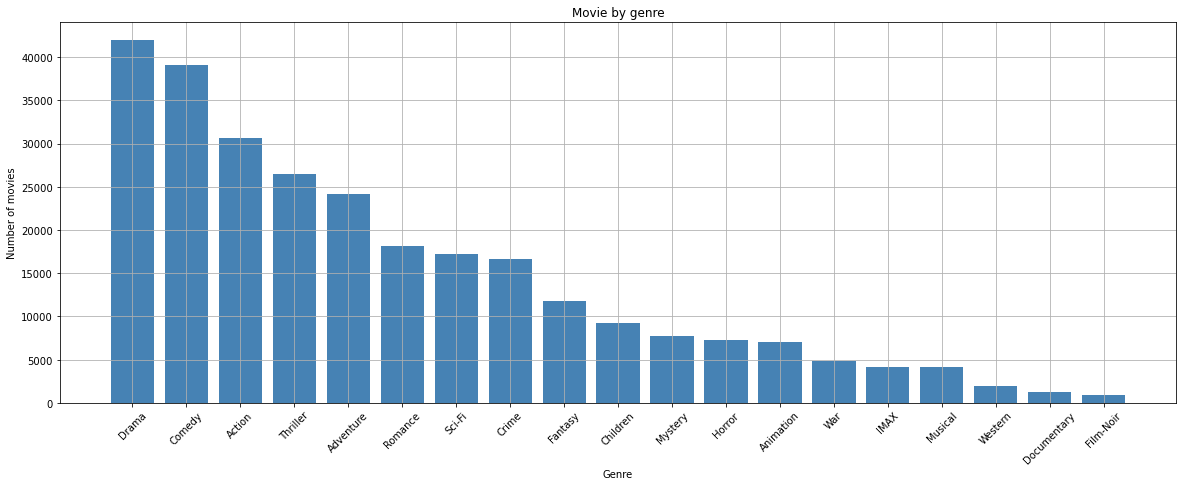

In [903]:
p.figure(figsize=(20,7))
gnr_lst = dfmvs1['genres'].apply(lambda mv_lst : str(mv_lst).split("|"))
gnr_cnt = {}

for mv_lst in gnr_lst:
    for genre in mv_lst:
        if(gnr_cnt.get(genre,False)):
            gnr_cnt[genre]=gnr_cnt[genre]+1
        else:
            gnr_cnt[genre] = 1
            
gnr_cnt.pop('(no genres listed)')
gnr_cnt = {k: v for k, v in sorted(gnr_cnt.items(), key=lambda item: item[1], reverse=True)}
p.bar(gnr_cnt.keys(),gnr_cnt.values(),color='steelblue')
p.title('Movie by genre')
p.xticks(rotation = 45)
p.xlabel('Genre')
p.ylabel('Number of movies')
p.grid()
p.show()

In [904]:
df_rtngs.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Distribution of users rating

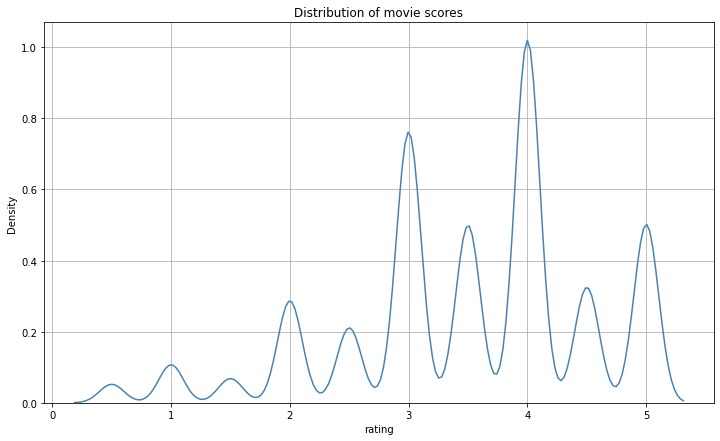

In [905]:
p.figure(figsize=(12,7))
#plot distribution of rating with the kde chart
sns.kdeplot(df_rtngs["rating"], color = 'steelblue');
p.title('Distribution of movie scores')
p.grid()
p.show()

In [906]:
print("Shape of the dataframes: \n"+ " Rating DataFrame: "+ str(df_rtngs.shape)+"\n Movies DataFrame"+ str(dfmv.shape))

Shape of the dataframes: 
 Rating DataFrame: (100836, 4)
 Movies DataFrame(9742, 3)


In [907]:
#merge the movie and ratings dataset to get ratings of the respective movies
combine_mv_scs = pd.merge(dfmv, df_rtngs, on='movieId', how='inner')

In [908]:
combine_mv_scs.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


In [909]:
#drop the timestamp column to remain with relevant attrs
combine_mv_scs = combine_mv_scs.drop('timestamp', axis=1)

In [910]:
#get shape of the resulting data
combine_mv_scs.shape

(100836, 5)

Grouping the rating based on user

In [911]:
#Group by the userid
scores_grouped_by_usrs = combine_mv_scs.groupby('userId').agg([np.size, np.mean])

In [912]:
scores_grouped_by_usrs.head(2)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448  232.0  4.366379
2           29  70350.275862   29.0  3.948276

In [913]:
#Remove movieid
scores_grouped_by_usrs = scores_grouped_by_usrs.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

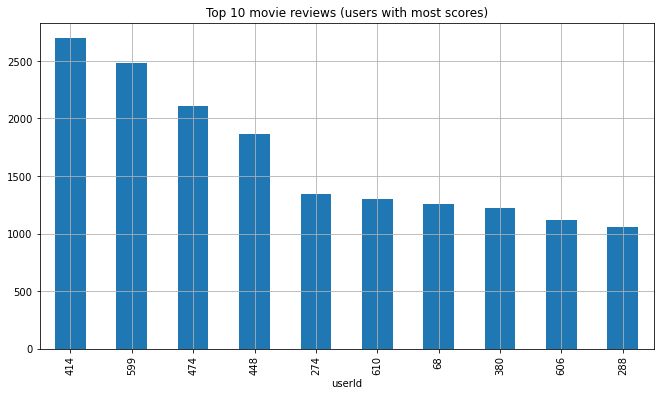

In [914]:
#plot the top 10 movies
scores_grouped_by_usrs['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (11,6))
p.title('Top 10 movie reviews (users with most scores)')
p.grid()
p.show()

In [915]:
#Group by movie id to get the mean rating of each movie
scores_mvs = combine_mv_scs.groupby('movieId').agg([np.mean], np.size)

In [916]:
scores_mvs.shape

(9724, 2)

In [917]:
scores_mvs.head(3)

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615


In [918]:
#Remove movieid
scores_mvs = scores_mvs.drop('userId', axis=1)

### Movies with high average rating

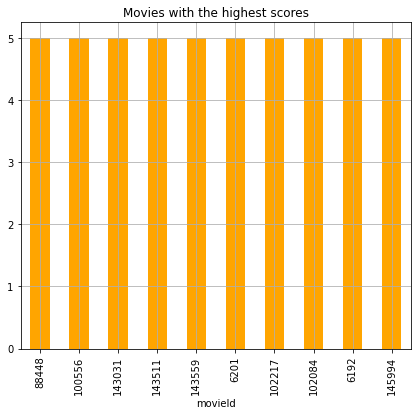

In [919]:
#Plot movies with the highest average rating
scores_mvs['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='bar',
                                                                                       figsize=(7,6), color = 'orange');
p.title('Movies with the highest scores')
p.grid()
p.show()

### Movies with low average rating

In [920]:
#Get movies that are rated less than 1.5
least_rated_mvs = scores_mvs['rating']['mean']< 1.5

In [921]:
#Subset the movies using the mentioned criterion
rated_low = scores_mvs[least_rated_mvs]

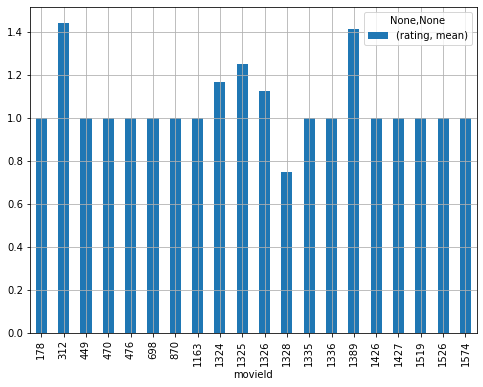

In [922]:
#Plot the movies
rated_low.head(20).plot(kind='bar', figsize=(8,6));
p.grid()

In [923]:
#Overview of 10 movies with the lowest rating
rated_low.head(10)

,rating
,mean
movieId,
178,1.000000
312,1.444444
449,1.000000
470,1.000000
476,1.000000
698,1.000000
870,1.000000
1163,1.000000


In [924]:
#Merge the ratings and movies dt
dfmvs = dfmv.merge(df_rtngs)
groupby = ['genres']
nonnormal = ['movieId']
dfmvs = dfmvs[dfmvs['genres'].isin(list(gnr_cnt.keys())[0:5])]

In [925]:
tstTable = TableOne(dfmvs,columns = ['genres', 'rating'],
                   groupby=groupby, pval=True)

In [926]:
tstTable

Grouped by genres                                                                                
                            Missing      Overall     Action Adventure       Comedy        Drama    Thriller P-Value
n                                          14320        186        19         7196         6291         628        
rating, n (%) 0.5                 0    191 (1.3)    4 (2.2)              136 (1.9)     44 (0.7)     7 (1.1)  <0.001
              1.0                      486 (3.4)   13 (7.0)   1 (5.3)    348 (4.8)     99 (1.6)    25 (4.0)        
              1.5                      324 (2.3)    6 (3.2)   1 (5.3)    256 (3.6)     49 (0.8)    12 (1.9)        
              2.0                     1198 (8.4)  31 (16.7)  7 (36.8)   828 (11.5)    287 (4.6)    45 (7.2)        
              2.5                      849 (5.9)   13 (7.0)              515 (7.2)    295 (4.7)    26 (4.1)        
              3.0                    2971 (20.7)  51 (27.4)  5 (26.3)  1614 (22.4)  1144 (18.2)  157 (25.0)        
              3.5                    1778 (12.4)  22 (11.8)  2 (10.5)   854 (11.9)   830 (13.2)   70 (11.1)        
              4.0                    3847 (26.9)  27 (14.5)  2 (10.5)  1586 (22.0)  2055 (32.7)  177 (28.2)        
              4.5                     1044 (7.3)   11 (5.9)              403 (5.6)    593 (9.4)    37 (5.9)        
              5.0                    1632 (11.4)    8 (4.3)   1 (5.3)    656 (9.1)   895 (14.2)   72 (11.5)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: rating.

In [927]:
tstTable.to_excel('summary_100k.xlsx')

In [928]:
#Geenrate statistics related to genres and ratings
tstTable = TableOne(dfmvs,columns = ['genres', 'rating'],
                   groupby=groupby, categorical=['genres'], nonnormal=nonnormal, pval=True, tukey_test=True)

display(tstTable)
#Save to excel for use in the report
tstTable.to_excel('summary_100k_tst.xlsx')

Grouped by genres                                                                                       
                                      Missing      Overall       Action   Adventure        Comedy         Drama     Thriller P-Value
n                                                    14320          186          19          7196          6291          628        
genres, n (%)     Action                    0    186 (1.3)  186 (100.0)                                                       <0.001
                  Adventure                       19 (0.1)               19 (100.0)                                                 
                  Comedy                       7196 (50.3)                           7196 (100.0)                                   
                  Drama                        6291 (43.9)                                         6291 (100.0)                     
                  Thriller                       628 (4.4)                                                       628 (100.0)        
rating, mean (SD)                           0    3.4 (1.1)    2.9 (1.1)   2.7 (1.0)     3.2 (1.1)     3.7 (0.9)    3.4 (1.0)  <0.001
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: genres.

#### Data Preparation

> (1)- Merge the dataframes to obtain complete information regarding a user, a movie and the corresponding interaction.

> (2)- Split the data into test and train.

##### Merge the dataframes

In [929]:
#get distribution of the ratings data
df_rtngs.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [930]:
dfmvs.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [931]:
#Merge the dataframes
movie_scs = dfmvs.merge(df_rtngs)
movie_scs = movie_scs
movie_scs.head()

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938
1,5,Father of the Bride Part II (1995),Comedy,31,3.0,850466642
2,5,Father of the Bride Part II (1995),Comedy,43,5.0,848994281
3,5,Father of the Bride Part II (1995),Comedy,45,3.0,959625102
4,5,Father of the Bride Part II (1995),Comedy,58,4.0,847719151


##### Split the dataframes to test and train sets

In [932]:
X = movie_scs[['userId', 'movieId']].values
y = movie_scs['rating'].values
#Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)


In [933]:
X = movie_scs[['userId', 'movieId']]
y = movie_scs['rating']
#Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)
X_trn.shape, X_tst.shape, y_trn.shape, y_tst.shape

((10024, 2), (4296, 2), (10024,), (4296,))

#### Modeling

### Step 1. Define an index vector of all unique users and movies

In [934]:
#Order the movies and users
c_mv = CategoricalDtype(sorted(movie_scs['movieId'].unique()), ordered=True)
c_usrr = CategoricalDtype(sorted(movie_scs['userId'].unique()), ordered=True)

In [935]:
print(len(c_mv.categories))
print(len(c_usrr.categories))

2150
586


In [936]:

trn, tst = train_test_split(X, test_size=0.30, random_state=420)
print(trn.shape)
print(tst.shape)

(10024, 2)
(4296, 2)


In [937]:
tst = X_tst.copy()
trn = X_trn.copy()

tstx = tst.copy()

tstx['userId'] = tstx['userId'].astype(c_usrr)

tstx['movieId'] = tstx['movieId'].astype(c_mv)

tst_pred = tstx.copy()

In [938]:
tstx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4296 entries, 533 to 2015
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   userId   4296 non-null   category
 1   movieId  4296 non-null   category
dtypes: category(2)
memory usage: 152.4 KB


### Step 2: Define a 1's and 0's binary sparse matrix of User-movies for trning set

In [939]:
trn_dt = csr_matrix((np.ones(len(trn)), (trn['userId'].astype(ct).cat.codes,
                                               trn['movieId'].astype(ct).cat.codes)), 
                  shape=( len(c_usrr.categories), len(c_mv.categories)))
print(f'{100*trn_dt.sum()/(trn_dt.shape[0]*trn_dt.shape[1])}% Sparsity')

0.7956186998968172% Sparsity


### Step 3. Run the model on the trning set

Models were tsting:

1. Cosine Similarity on movies

2. Non-negative matrix factorization

3. Neural Collaborative Filtering


Evaluation:
- Recall- percentage of 1s that are found in the Test set
- MPR- Mean Percentile Rank score


#### Cosine Similarity
Doing this in bits for the tst set so that we don't run into memory issues.   For the recall measure, if the track's relative percentile is < 0.5 then we can consider it as a 1

In [940]:
def cos(dt, pred):
    
    #Cosine similarity model to generate a matrix and determine the closest recommendation depending on the similarity matrix
    # normalize to obtain % importance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    # implement model
    #s = similarity
    s = cosine_similarity(scaled_df.transpose())
    s[np.diag_indices(s.shape[0])] = 0
    denom = np.asarray(s.sum(axis=1)).reshape(-1)

    # implement per bit to handle memory issues
    user_index = pred['userId'].cat.codes.values
    movie_index = pred['movieId'].cat.codes.values

    number_of_bits = 30
    bits = np.array_split(np.arange(scaled_df.shape[0]), number_of_bits)
    #R = result
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (scaled_df[indexx].dot(s)) / denom
        scr = (-scr).argsort() / denom.shape[0]
        sl = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sl] - prev_mx, movie_index[sl]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)


# Evaluate performance of the model
Recommendations = cos(trn_dt, tstx)
mpr_cosine_sim = Recommendations.sum()/len(tstx)
print('MPR:', round(mpr_cosine_sim,5))
r_cosine_sim = (Recommendations < 0.5).sum()/len(tstx)
print('Model Recall rate:',round(r_cosine_sim, 5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
MPR: 0.4244
Model Recall rate: 0.58822


#### Neural Collaborative Filtering

In [941]:
# Create the trning Set
sample_size_with_no_links = int(len(trn)*0.2)
n_usrs = c_usrr.categories.shape[0]
num_of_movies = c_mv.categories.shape[0]
# get trning set
trnx_usrs = trn['userId'].astype(ct).cat.codes.values
trnx_movies = trn['movieId'].astype(ct).cat.codes.values
trn_t = np.ones(len(trnx_usrs))
# add some negative samples
u = np.random.randint(n_usrs, size=sample_size_with_no_links)
i = np.random.randint(num_of_movies, size=sample_size_with_no_links)
non_neg_indexx = np.where(trn_dt[u,i] == 0)
trnx_usrs = np.concatenate([trnx_usrs, u[non_neg_indexx[1]]])
trnx_movies = np.concatenate([trnx_movies, i[non_neg_indexx[1]]])
trn_t = np.concatenate([trn_t, np.zeros(u[non_neg_indexx[1]].shape[0])])
print((trnx_usrs.shape, trnx_movies.shape, trn_t.shape))

# shuffle the data
X = np.stack([trnx_usrs, trnx_movies, trn_t], axis=1)
np.random.shuffle(X)

((12010,), (12010,), (12010,))


##### Model parameters

In [942]:
#Output activation
actv = 'sigmoid'
#Intializer
intt = 'lecun_uniform'
#Layer name
nem = 'prediction'
#user input
u_t = 'user_input'
#item input
i_p = 'item_input'

In [943]:

#usr_lt = user lt
def neural_network(number_of_usrs, num_movies, ld, regs=[0,0]):
    # model vars
    #user_p = user input
    usr_p = Input(shape=(1,), dtype='int64', name = u_t)
    itm_input = Input(shape=(1,), dtype='int64', name = i_p)
    #ld = lt dimension
    #mbds = embeddings
    #mbds_usrr = user embedding
    mbds_usrr = Embedding(input_dim = number_of_usrs, output_dim = ld, name = 'user_mbds', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    #mbds_itm = item emdeddings 
    mbds_itm = Embedding(input_dim = num_movies, output_dim = ld, name = 'itm_mbds',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # essential to define an embedding vector!
    usr_lt = Flatten()(mbds_usrr(usr_p))
    itm_lt = Flatten()(mbds_itm(itm_input))
    
    # user-itm embedding productper element
    prdvec = merge.Multiply()([usr_lt, itm_lt])
    
    # Final prd layer
    prd = Dense(1, activation=actv, kernel_initializer=intt, name = nem)(prdvec)
    #retutn md = model
    md = Model(inputs=[usr_p, itm_input], outputs=prd)
    
    return md

# create the recall function
def rc(y_rl, y_p):
    tp = Q.sum(Q.round(Q.clip(y_rl * y_p, 0, 1)))
    pos_pt = Q.sum(Q.round(Q.clip(y_rl, 0, 1)))
    rc = tp / (pos_pt + Q.epsilon())
    return rc

mdl = neural_network(n_usrs, num_of_movies, 50, regs = [0,0])

In [944]:
mdl.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_mbds (Embedding)           (None, 1, 50)        29300       user_input[0][0]                 
__________________________________________________________________________________________________
itm_mbds (Embedding)            (None, 1, 50)        107500      item_input[0][0]                 
___________________________________________________________________________________________

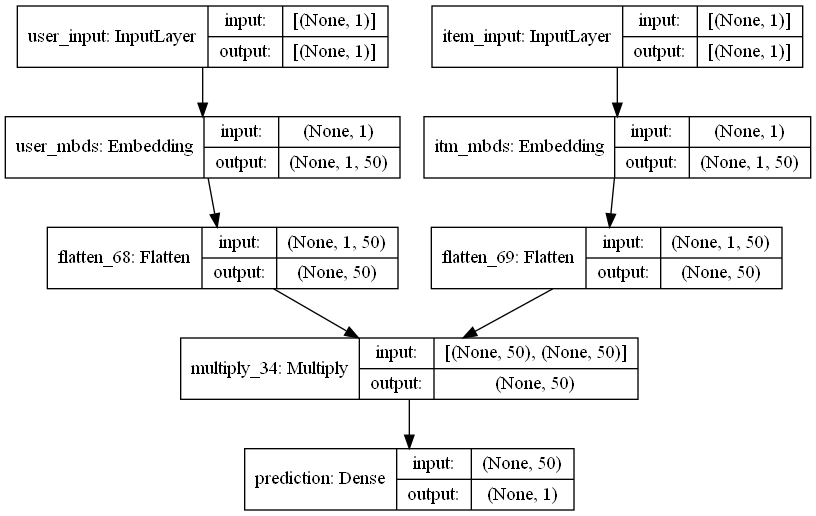

In [945]:
from keras.utils.vis_utils import plot_model
plot_model(mdl, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [946]:
#Output activation
actv = 'sigmoid'
#Intializer
intt = 'lecun_uniform'
#Layer name
nem = 'prediction'
#user input
u_t = 'user_input'
#item input
i_p = 'item_input'

In [947]:


#usr_lt = user lt
def neural_network(number_of_usrs, num_movies, ld, regs=[0,0]):
    # model vars
    #user_p = user input
    usr_p = Input(shape=(1,), dtype='int64', name = u_t)
    itm_input = Input(shape=(1,), dtype='int64', name = i_p)
    #ld = lt dimension
    #mbds = embeddings
    #mbds_usrr = user embedding
    mbds_usrr = Embedding(input_dim = number_of_usrs, output_dim = ld, name = 'user_mbds', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    #mbds_itm = item emdeddings 
    mbds_itm = Embedding(input_dim = num_movies, output_dim = ld, name = 'itm_mbds',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # essential to define an embedding vector!
    usr_lt = Flatten()(mbds_usrr(usr_p))
    itm_lt = Flatten()(mbds_itm(itm_input))
    
    # user-itm embedding productper element
    prdvec = merge.Multiply()([usr_lt, itm_lt])
    
    # Final prd layer
    prd = Dense(1, activation=actv, kernel_initializer=intt, name = nem)(prdvec)
    #retutn md = model
    md = Model(inputs=[usr_p, itm_input], outputs=prd)
    
    return md


# create the model
def rc(yt, yp):
    tp = K.sum(K.round(K.clip(yt * yp, 0, 1)))
    pos_pt = K.sum(K.round(K.clip(yt, 0, 1)))
    recall = tp / (pos_pt + K.epsilon())
    return recall

mdl = neural_network(n_usrs, num_of_movies, 50, regs = [0,0])

mdl.compile(optimizer=RMSprop(lr=0.001), metrics = ['accuracy', rc],  loss='binary_crossentropy')

In [948]:
# trn the Model
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
h =  mdl.fit([X[:,0], X[:,1]], X[:,2], batch_size=150000, epochs=20, validation_split = 0.1, verbose=1, callbacks = [early_stop])
score = mdl.evaluate([tstx['userId'].cat.codes.values, tstx['movieId'].cat.codes.values], np.ones(tstx.shape[0]), verbose=1, batch_size=100000)
print(f'tst Loss: {score[0]}   |   tst Recall: {score[1]}')

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.6932 - accuracy: 0.4986 - rc: 0.4985 - val_loss: 0.6920 - val_accuracy: 0.8451 - val_rc: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 67ms/step - loss: 0.6920 - accuracy: 0.8335 - rc: 1.0000 - val_loss: 0.6913 - val_accuracy: 0.8451 - val_rc: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 62ms/step - loss: 0.6912 - accuracy: 0.8335 - rc: 1.0000 - val_loss: 0.6906 - val_accuracy: 0.8451 - val_rc: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 44ms/step - loss: 0.6905 - accuracy: 0.8335 - rc: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.8451 - val_rc: 1.0000
Epoch 00004: early stopping
1/1 [==============================] - 0s 225ms/step - loss: 0.6886 - accuracy: 1.0000 - rc: 1.0000
tst Loss: 0.6886122226715088   |   tst Recall: 1.0


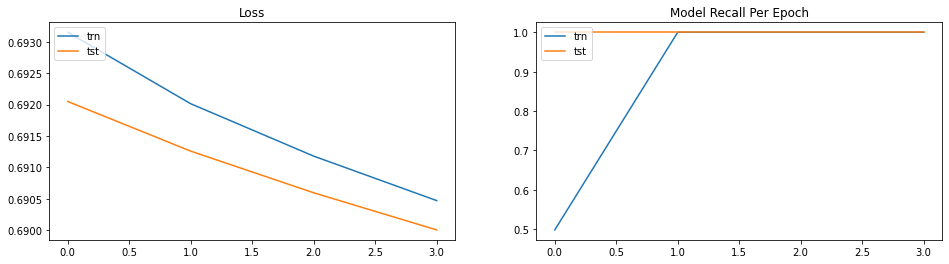

In [949]:
# Plot it
import matplotlib.pyplot as p
fig, (axis1,axis2) = p.subplots(1,2, figsize=(16,4))
axis1.plot(h.history['loss'])
axis1.plot(h.history['val_loss'])
axis1.set_title('Loss')
axis1.legend(['trn', 'tst'], loc='upper left')
axis2.plot(h.history['rc'])
axis2.plot(h.history['val_rc'])
axis2.set_title('Model Recall Per Epoch')
axis2.legend(['trn', 'tst'], loc='upper left')
p.show()

In [951]:

# compute MPR
# we implement per bit to handle memory issues
user_index = tstx['userId'].cat.codes.values
movie_index = tstx['movieId'].cat.codes.values
number_of_bits = 10
bits = np.array_split(np.arange(n_usrs), number_of_bits)
rs = []
prev_mx = 0
for i,indexx in enumerate(bits):
    print(f'Implementing bit : {i+1}/{number_of_bits}')
    cross_mvId = np.transpose([np.tile(np.arange(num_of_movies), len(indexx)), np.repeat(indexx, len(np.arange(num_of_movies)))])
    score = mdl.predict([cross_mvId[:,1], cross_mvId[:,0]], batch_size=50000, verbose=1).reshape(indexx.shape[0], num_of_movies)
    score = (-score).argsort() / score.shape[1]
    sel = (user_index >= indexx.min()) & (user_index <= indexx.max())
    bit_score = np.asarray(score[user_index[sel] - prev_mx, movie_index[sel]]).reshape(-1)
    rs.append(bit_score)
    prev_mx = indexx.max() + 1
mpr_N_C_F = np.concatenate(rs).sum()/len(tstx)
print(f'N_C_F MPR: {mpr_N_C_F:.5f}')
rc_deep_reac = (np.concatenate(rs) < 0.5).sum()/len(tstx)
print(f'N_C_F Model Recall rate: {rc_deep_reac:.5f}')

Implementing bit : 1/10
3/3 [==============================] - 0s 11ms/step
Implementing bit : 2/10
3/3 [==============================] - 0s 14ms/step
Implementing bit : 3/10
3/3 [==============================] - 0s 19ms/step
Implementing bit : 4/10
3/3 [==============================] - 0s 18ms/step
Implementing bit : 5/10
3/3 [==============================] - 0s 16ms/step
Implementing bit : 6/10
3/3 [==============================] - ETA:  - 0s 16ms/step
Implementing bit : 7/10
3/3 [==============================] - 0s 22ms/step
Implementing bit : 8/10
3/3 [==============================] - 0s 16ms/step
Implementing bit : 9/10
3/3 [==============================] - 0s 13ms/step
Implementing bit : 10/10
3/3 [==============================] - 0s 13ms/step
N_C_F MPR: 0.49553
N_C_F Model Recall rate: 0.50675


In [952]:
#Make movie predictions using the deep learning model
tst_pred['score'] = list(np.concatenate(rs))
#Select the top 5 movieIds to recommend to a user
tsf = tst_pred.sort_values(['score'],ascending=False).groupby('userId').head(5)
tsf1 = tsf.sort_values('userId')
tsf1 = tsf1[['userId', 'movieId']]
tsf1.columns = ['userId', 'Recommended movieId']
tsf1.head(10)

,userId,Recommended movieId
7524,1,3253
4983,1,1954
3006,1,954
898,1,223
1901,1,441
13251,2,89774
3366,3,1124
11245,3,7899
6220,4,2599
9117,4,4020


#### Non-Negative Matrix Factorization

In [953]:
def nmf(dt, prd,mdl):
    # normalize to obtain % significance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    S = mdl.fit_transform(scaled_df)
    K = mdl.components_

    # implement per bit to handle memory issues
    user_index = prd['userId'].cat.codes.values
    movie_index = prd['movieId'].cat.codes.values
    number_of_bits = 30
    bits = np.array_split(np.arange(S.shape[0]), number_of_bits)
    #r = Results
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (S[indexx].dot(K))
        scr = (-scr).argsort() / scr.shape[1]
        sel = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sel] - prev_mx, movie_index[sel]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)

Kk = 2

# NMF
#NNDSVD to handle sparsity
mdl_nmf = NMF(n_components = Kk, init = 'nndsvd', max_iter = 1000, tol = 0.1, random_state = 1)
Recommendations1 = nmf(trn_dt, tstx, mdl_nmf)
mpr_Non_Negative_Matrix_Factorization = Recommendations1.sum()/len(tstx)
print(f'NMF MPR', round(mpr_Non_Negative_Matrix_Factorization,5))
rec_Non_Negative_Matrix_Factorization = (Recommendations1 < 0.5).sum()/len(tstx)
print('mdl Recall rate', round(rec_Non_Negative_Matrix_Factorization,5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
NMF MPR 0.40487
mdl Recall rate 0.60521


# 10M MovieLens dataset

>Source: https://files.grouplens.org/datasets/movielens/ml-10m.zip

In [954]:
# Reading scores file
scores = pd.read_csv('ml-10m/ratings.dat', sep='::',
                      names=['userId', 'movieId', 'rating', 'timestamp']
                      ).sort_values("timestamp")
# Reading movies file
movies = pd.read_csv('ml-10m/movies.dat', sep='::',
                     header=None, names=['movieId', 'title', 'genres'])

In [955]:
dfmv = movies
df_rtngs = scores

In [956]:
dfmvs1 = dfmv.merge(df_rtngs)[['genres', 'rating']]

#### Examine data sparsity

In [957]:
ct = 'category' #Define global category descriptor
usrs = np.sort(scores.userId.unique()).tolist() # Get the unique customers
mvs = list(scores.movieId.unique()) # Get the unique products that were watched
rtng = list(scores.rating) # All of the watch history
r = scores.userId.astype(ct, usrs).cat.codes
# pull row indices
cols = scores.movieId.astype(ct, mvs).cat.codes
# pull column indices
usr_itm = sps.csr_matrix((rtng, (r, cols)), shape=(len(usrs), len(mvs)))
mtrx_sz = usr_itm.shape[0]*usr_itm.shape[1] # Total possible links
times_watched = len(usr_itm.nonzero()[0]) # Number of mvs interacted with
#sparsity
sprs = 100*(1 - (1.0*times_watched/mtrx_sz))

In [958]:
print(times_watched, 'links')

10000054 links


In [959]:
print(len(movies), 'movies')

10681 movies


In [960]:
print(len(usrs), 'Users')

69878 Users


### Exploratory Data Analysis(EDA)

In [961]:
dfmv.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

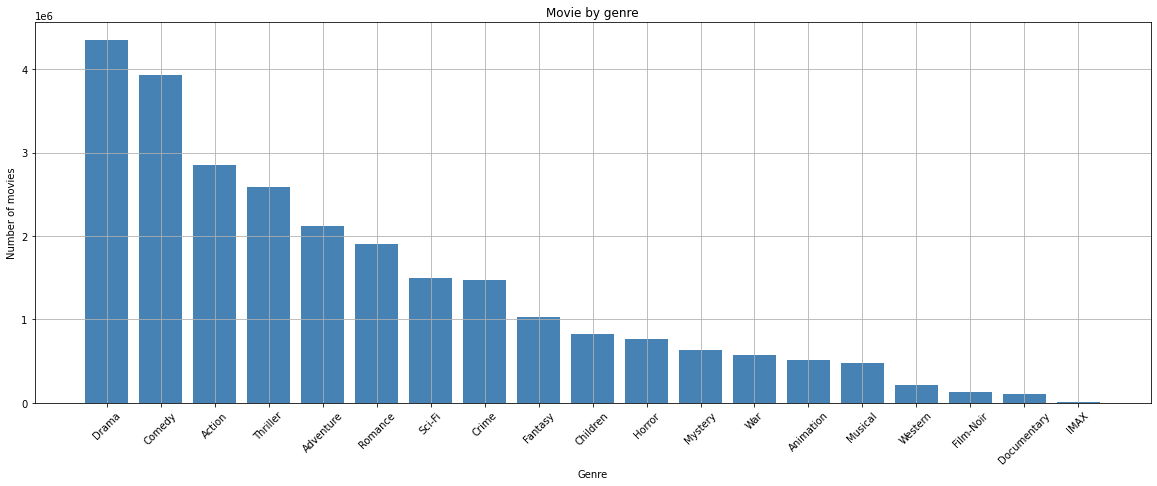

In [962]:
p.figure(figsize=(20,7))
gnr_lst = dfmvs1['genres'].apply(lambda mv_lst : str(mv_lst).split("|"))
gnr_cnt = {}

for mv_lst in gnr_lst:
    for genre in mv_lst:
        if(gnr_cnt.get(genre,False)):
            gnr_cnt[genre]=gnr_cnt[genre]+1
        else:
            gnr_cnt[genre] = 1
            
gnr_cnt.pop('(no genres listed)')
gnr_cnt = {k: v for k, v in sorted(gnr_cnt.items(), key=lambda item: item[1], reverse=True)}
p.bar(gnr_cnt.keys(),gnr_cnt.values(),color='steelblue')
p.title('Movie by genre')
p.xticks(rotation = 45)
p.xlabel('Genre')
p.ylabel('Number of movies')
p.grid()
p.show()

In [963]:
df_rtngs.head(5)

,userId,movieId,rating,timestamp
5167075,36955,21,3.0,789652009
5167081,36955,47,5.0,789652009
5167124,36955,1079,3.0,789652009
4961485,35435,45,5.0,822873600
4961483,35435,21,5.0,822873600


### Distribution of users rating

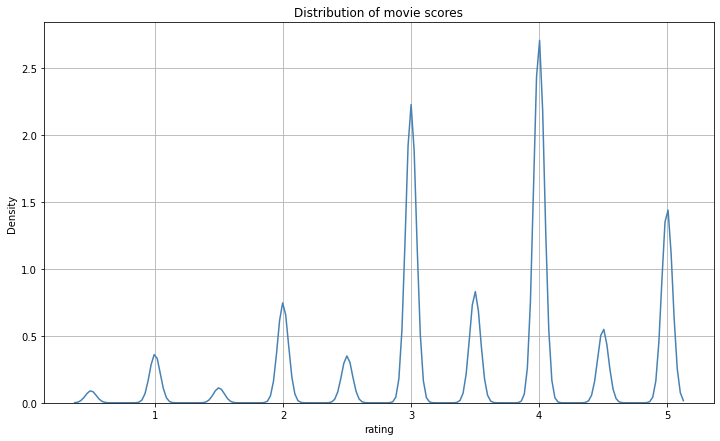

In [964]:
p.figure(figsize=(12,7))
#plot distribution of rating with the kde chart
sns.kdeplot(df_rtngs["rating"], color = 'steelblue');
p.title('Distribution of movie scores')
p.grid()
p.show()

In [965]:
print("Shape of the dataframes: \n"+ " Rating DataFrame: "+ str(df_rtngs.shape)+"\n Movies DataFrame"+ str(dfmv.shape))

Shape of the dataframes: 
 Rating DataFrame: (10000054, 4)
 Movies DataFrame(10681, 3)


In [966]:
#merge the movie and ratings dataset to get ratings of the respective movies
combine_mv_scs = pd.merge(dfmv, df_rtngs, on='movieId', how='inner')

In [967]:
combine_mv_scs.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,35139,4.0,822873600
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,36008,5.0,823185203


In [968]:
#drop the timestamp column to remain with relevant attrs
combine_mv_scs = combine_mv_scs.drop('timestamp', axis=1)

In [969]:
#get shape of the resulting data
combine_mv_scs.shape

(10000054, 5)

Grouping the rating based on user

In [970]:
#Group by the userid
scores_grouped_by_usrs = combine_mv_scs.groupby('userId').agg([np.size, np.mean])

In [971]:
scores_grouped_by_usrs.head(2)

movieId             rating     
          size        mean   size mean
userId                                
1           22  411.681818   22.0  5.0
2           20  785.550000   20.0  3.2

In [972]:
#Remove movieid
scores_grouped_by_usrs = scores_grouped_by_usrs.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

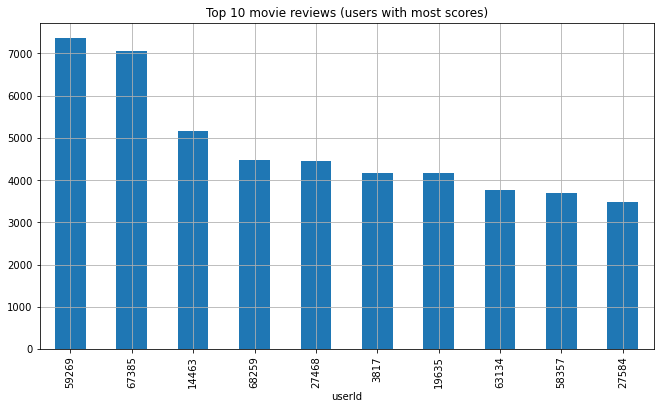

In [973]:
#plot the top 10 movies
scores_grouped_by_usrs['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (11,6))
p.title('Top 10 movie reviews (users with most scores)')
p.grid()
p.show()

In [974]:
#Group by movie id to get the mean rating of each movie
scores_mvs = combine_mv_scs.groupby('movieId').agg([np.mean], np.size)

In [975]:
scores_mvs.shape

(10677, 2)

In [976]:
scores_mvs.head(3)

,userId,rating
,mean,mean
movieId,,
1,35520.163787,3.928769
2,35868.424701,3.208070
3,35311.554685,3.150385


In [977]:
#Remove movieid
scores_mvs = scores_mvs.drop('userId', axis=1)

### Movies with high average rating

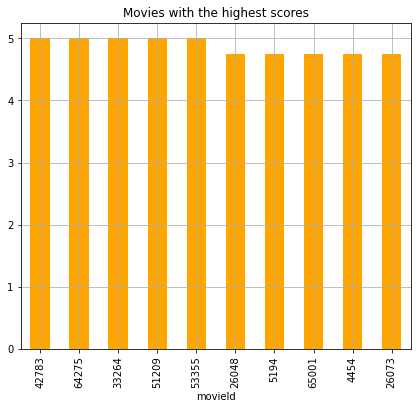

In [978]:
#Plot movies with the highest average rating
scores_mvs['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='bar',
                                                                                       figsize=(7,6), color = 'orange');
p.title('Movies with the highest scores')
p.grid()
p.show()

### Movies with low average rating

In [979]:
#Get movies that are rated less than 1.5
least_rated_mvs = scores_mvs['rating']['mean']< 1.5

In [980]:
#Subset the movies using the mentioned criterion
rated_low = scores_mvs[least_rated_mvs]

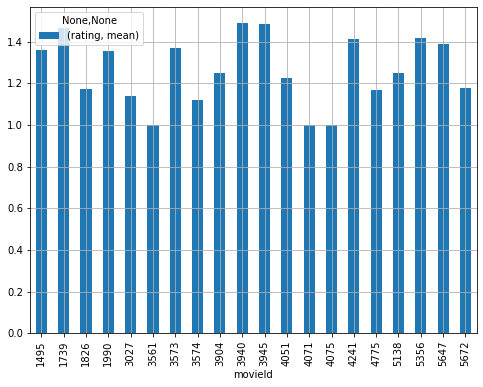

In [981]:
#Plot the movies
rated_low.head(20).plot(kind='bar', figsize=(8,6));
p.grid()

In [982]:
#Overview of 10 movies with the lowest rating
rated_low.head(10)

,rating
,mean
movieId,
1495,1.360227
1739,1.464286
1826,1.175214
1990,1.356436
3027,1.138889
3561,1.000000
3573,1.367647
3574,1.120253


In [983]:
#Merge the ratings and movies dt
dfmvs = dfmv.merge(df_rtngs)
groupby = ['genres']
nonnormal = ['movieId']
dfmvs = dfmvs[dfmvs['genres'].isin(list(gnr_cnt.keys())[0:5])]

In [984]:
tstTable = TableOne(dfmvs,columns = ['genres', 'rating'],
                   groupby=groupby, pval=True)

In [985]:
tstTable

Grouped by genres                                                                                            
                            Missing        Overall       Action   Adventure         Comedy          Drama      Thriller P-Value
n                                          1728711        27208        2549         778596         815084        105274        
rating, n (%) 0.5                 0    16147 (0.9)    428 (1.6)    53 (2.1)    11301 (1.5)     3895 (0.5)     470 (0.4)  <0.001
              1.0                      76002 (4.4)   2666 (9.8)   245 (9.6)    50350 (6.5)    19796 (2.4)    2945 (2.8)        
              1.5                      19674 (1.1)    614 (2.3)    62 (2.4)    13280 (1.7)     4938 (0.6)     780 (0.7)        
              2.0                     145057 (8.4)  3750 (13.8)  365 (14.3)   86532 (11.1)    46460 (5.7)    7950 (7.6)        
              2.5                      61721 (3.6)   1400 (5.1)   137 (5.4)    35875 (4.6)    20886 (2.6)    3423 (3.3)        
              3.0                    422363 (24.4)  9217 (33.9)  698 (27.4)  209441 (26.9)  175215 (21.5)  27792 (26.4)        
              3.5                     142369 (8.2)   1763 (6.5)   243 (9.5)    65123 (8.4)    66364 (8.1)    8876 (8.4)        
              4.0                    500639 (29.0)  5344 (19.6)  524 (20.6)  192115 (24.7)  267806 (32.9)  34850 (33.1)        
              4.5                      88418 (5.1)    434 (1.6)    69 (2.7)    31050 (4.0)    52679 (6.5)    4186 (4.0)        
              5.0                    256321 (14.8)   1592 (5.9)   153 (6.0)   83529 (10.7)  157045 (19.3)  14002 (13.3)

In [986]:
tstTable.to_excel('summary_10M.xlsx')

In [987]:
#Geenrate statistics related to genres and ratings
tstTable = TableOne(dfmvs,columns = ['genres', 'rating'],
                   groupby=groupby, categorical=['genres'], nonnormal=nonnormal, pval=True, tukey_test=True)

display(tstTable)
#Save to excel for use in the report
tstTable.to_excel('summary_10M_tst.xlsx')

Grouped by genres                                                                                                    
                                      Missing        Overall         Action     Adventure          Comedy           Drama        Thriller P-Value
n                                                    1728711          27208          2549          778596          815084          105274        
genres, n (%)     Action                    0    27208 (1.6)  27208 (100.0)                                                                <0.001
                  Adventure                       2549 (0.1)                 2549 (100.0)                                                        
                  Comedy                       778596 (45.0)                               778596 (100.0)                                        
                  Drama                        815084 (47.1)                                               815084 (100.0)                        
                  Thriller                      105274 (6.1)                                                               105274 (100.0)        
rating, mean (SD)                           0      3.5 (1.1)      2.9 (1.1)     3.0 (1.1)       3.2 (1.1)       3.7 (1.0)       3.5 (1.0)  <0.001
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: genres.

#### Data Preparation

> (1)- Merge the dataframes to obtain complete information regarding a user, a movie and the corresponding interaction.

> (2)- Split the data into test and train.

##### Merge the dataframes

In [988]:
#get distribution of the ratings data
df_rtngs.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [989]:
dfmvs.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [990]:
#Merge the dataframes
movie_scs = dfmvs.merge(df_rtngs)
movie_scs = movie_scs
movie_scs.head()

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,36008,2.0,823185224
1,5,Father of the Bride Part II (1995),Comedy,36304,4.0,823264601
2,5,Father of the Bride Part II (1995),Comedy,38104,4.0,825006881
3,5,Father of the Bride Part II (1995),Comedy,38206,2.0,825009968
4,5,Father of the Bride Part II (1995),Comedy,38326,4.0,825080156


##### Split the dataframes to test and train sets

In [991]:
X = movie_scs[['userId', 'movieId']].values
y = movie_scs['rating'].values
#Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)


In [992]:
X = movie_scs[['userId', 'movieId']]
y = movie_scs['rating']
#Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)
X_trn.shape, X_tst.shape, y_trn.shape, y_tst.shape

((1210097, 2), (518614, 2), (1210097,), (518614,))

#### Modeling

### Step 1. Define an index vector of all unique users and movies

In [993]:
#Order the movies and users
c_mv = CategoricalDtype(sorted(movie_scs['movieId'].unique()), ordered=True)
c_usrr = CategoricalDtype(sorted(movie_scs['userId'].unique()), ordered=True)

In [994]:
print(len(c_mv.categories))
print(len(c_usrr.categories))

3103
69076


In [995]:

trn, tst = train_test_split(X, test_size=0.30, random_state=420)
print(trn.shape)
print(tst.shape)

(1210097, 2)
(518614, 2)


In [996]:
tst = X_tst.copy()
trn = X_trn.copy()

tstx = tst.copy()

tstx['userId'] = tstx['userId'].astype(c_usrr)

tstx['movieId'] = tstx['movieId'].astype(c_mv)

tst_pred = tstx.copy()

In [997]:
tstx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518614 entries, 1713321 to 710290
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   userId   518614 non-null  category
 1   movieId  518614 non-null  category
dtypes: category(2)
memory usage: 9.6 MB


### Step 2: Define a 1's and 0's binary sparse matrix of User-movies for trning set

In [998]:
trn_dt = csr_matrix((np.ones(len(trn)), (trn['userId'].astype(ct).cat.codes,
                                               trn['movieId'].astype(ct).cat.codes)), 
                  shape=( len(c_usrr.categories), len(c_mv.categories)))
print(f'{100*trn_dt.sum()/(trn_dt.shape[0]*trn_dt.shape[1])}% Sparsity')

0.564561460390921% Sparsity


### Step 3. Run the model on the training set

Models were tsting:

1. Cosine Similarity on movies

2. Non-negative matrix factorization

3. Neural Collaborative Filtering


Evaluation:
- Recall: % of 1s in the tst set
- MPR: Mean Percentile Rank

#### Cosine Similarity
Doing this in bits for the tst set so that we don't run into memory issues.   For the recall measure, if the track's relative percentile is < 0.5 then its a 1

In [999]:
def cos(dt, pred):
    
    #Cosine similarity model to generate a matrix and determine the closest recommendation depending on the similarity matrix
    # normalize to obtain % importance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    # implement model
    #s = similarity
    s = cosine_similarity(scaled_df.transpose())
    s[np.diag_indices(s.shape[0])] = 0
    denom = np.asarray(s.sum(axis=1)).reshape(-1)

    # implement per bit to handle memory issues
    user_index = pred['userId'].cat.codes.values
    movie_index = pred['movieId'].cat.codes.values

    number_of_bits = 30
    bits = np.array_split(np.arange(scaled_df.shape[0]), number_of_bits)
    #R = result
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (scaled_df[indexx].dot(s)) / denom
        scr = (-scr).argsort() / denom.shape[0]
        sl = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sl] - prev_mx, movie_index[sl]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)


# Evaluate performance of the model
Recommendations = cos(trn_dt, tstx)
mpr_cosine_sim = Recommendations.sum()/len(tstx)
print('MPR:', round(mpr_cosine_sim,5))
r_cosine_sim = (Recommendations < 0.5).sum()/len(tstx)
print('Model Recall rate:',round(r_cosine_sim, 5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
MPR: 0.40586
Model Recall rate: 0.64692


#### Neural Collaborative Filtering

In [1000]:
# Create the trning Set
sample_size_with_no_links = int(len(trn)*0.2)
n_usrs = c_usrr.categories.shape[0]
num_of_movies = c_mv.categories.shape[0]
# get trning set
trnx_usrs = trn['userId'].astype(ct).cat.codes.values
trnx_movies = trn['movieId'].astype(ct).cat.codes.values
trn_t = np.ones(len(trnx_usrs))
# add some negative samples
u = np.random.randint(n_usrs, size=sample_size_with_no_links)
i = np.random.randint(num_of_movies, size=sample_size_with_no_links)
non_neg_indexx = np.where(trn_dt[u,i] == 0)
trnx_usrs = np.concatenate([trnx_usrs, u[non_neg_indexx[1]]])
trnx_movies = np.concatenate([trnx_movies, i[non_neg_indexx[1]]])
trn_t = np.concatenate([trn_t, np.zeros(u[non_neg_indexx[1]].shape[0])])
print((trnx_usrs.shape, trnx_movies.shape, trn_t.shape))

# shuffle the data
X = np.stack([trnx_usrs, trnx_movies, trn_t], axis=1)
np.random.shuffle(X)

((1450766,), (1450766,), (1450766,))


##### Model parameters

In [1001]:
#Output activation
actv = 'sigmoid'
#Intializer
intt = 'lecun_uniform'
#Layer name
nem = 'prediction'
#user input
u_t = 'user_input'
#item input
i_p = 'item_input'

In [1002]:

#usr_lt = user lt
def neural_network(number_of_usrs, num_movies, ld, regs=[0,0]):
    # model vars
    #user_p = user input
    usr_p = Input(shape=(1,), dtype='int64', name = u_t)
    itm_input = Input(shape=(1,), dtype='int64', name = i_p)
    #ld = lt dimension
    #mbds = embeddings
    #mbds_usrr = user embedding
    mbds_usrr = Embedding(input_dim = number_of_usrs, output_dim = ld, name = 'user_mbds', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    #mbds_itm = item emdeddings 
    mbds_itm = Embedding(input_dim = num_movies, output_dim = ld, name = 'itm_mbds',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # essential to define an embedding vector!
    usr_lt = Flatten()(mbds_usrr(usr_p))
    itm_lt = Flatten()(mbds_itm(itm_input))
    
    # user-itm embedding productper element
    prdvec = merge.Multiply()([usr_lt, itm_lt])
    
    # Final prd layer
    prd = Dense(1, activation=actv, kernel_initializer=intt, name = nem)(prdvec)
    #retutn md = model
    md = Model(inputs=[usr_p, itm_input], outputs=prd)
    
    return md

# create the recall function
def rc(y_rl, y_p):
    tp = Q.sum(Q.round(Q.clip(y_rl * y_p, 0, 1)))
    pos_pt = Q.sum(Q.round(Q.clip(y_rl, 0, 1)))
    rc = tp / (pos_pt + Q.epsilon())
    return rc

mdl = neural_network(n_usrs, num_of_movies, 50, regs = [0,0])

In [1003]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_mbds (Embedding)           (None, 1, 50)        36800       user_input[0][0]                 
__________________________________________________________________________________________________
itm_mbds (Embedding)            (None, 1, 50)        78050       item_input[0][0]                 
___________________________________________________________________________________________

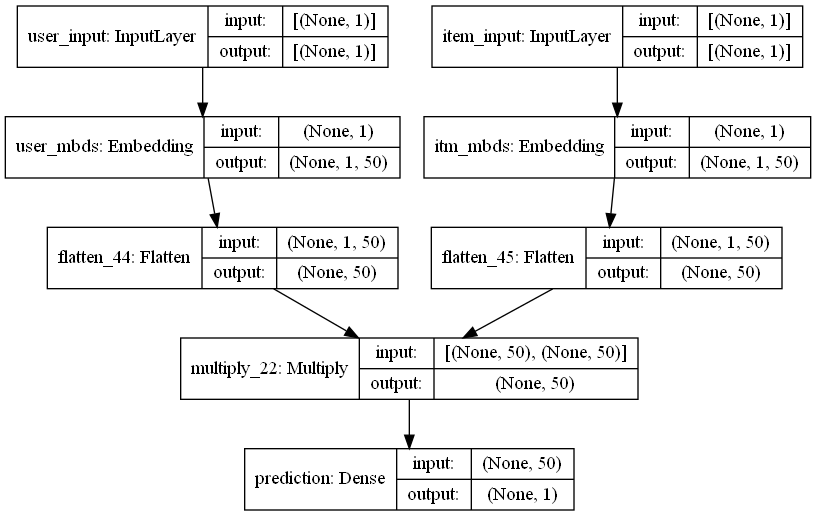

In [1004]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1005]:
#Output activation
actv = 'sigmoid'
#Intializer
intt = 'lecun_uniform'
#Layer name
nem = 'prediction'
#user input
u_t = 'user_input'
#item input
i_p = 'item_input'

In [1006]:


#usr_lt = user lt
def neural_network(number_of_usrs, num_movies, ld, regs=[0,0]):
    # model vars
    #user_p = user input
    usr_p = Input(shape=(1,), dtype='int64', name = u_t)
    itm_input = Input(shape=(1,), dtype='int64', name = i_p)
    #ld = lt dimension
    #mbds = embeddings
    #mbds_usrr = user embedding
    mbds_usrr = Embedding(input_dim = number_of_usrs, output_dim = ld, name = 'user_mbds', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    #mbds_itm = item emdeddings 
    mbds_itm = Embedding(input_dim = num_movies, output_dim = ld, name = 'itm_mbds',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # essential to define an embedding vector!
    usr_lt = Flatten()(mbds_usrr(usr_p))
    itm_lt = Flatten()(mbds_itm(itm_input))
    
    # user-itm embedding productper element
    prdvec = merge.Multiply()([usr_lt, itm_lt])
    
    # Final prd layer
    prd = Dense(1, activation=actv, kernel_initializer=intt, name = nem)(prdvec)
    #retutn md = model
    md = Model(inputs=[usr_p, itm_input], outputs=prd)
    
    return md


# create the model
def rc(yt, yp):
    tp = K.sum(K.round(K.clip(yt * yp, 0, 1)))
    pos_pt = K.sum(K.round(K.clip(yt, 0, 1)))
    recall = tp / (pos_pt + K.epsilon())
    return recall

mdl = neural_network(n_usrs, num_of_movies, 50, regs = [0,0])

mdl.compile(optimizer=RMSprop(lr=0.001), metrics = ['accuracy', rc],  loss='binary_crossentropy')

In [1007]:
# trn the Model
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
h =  mdl.fit([X[:,0], X[:,1]], X[:,2], batch_size=150000, epochs=20, validation_split = 0.1, verbose=1, callbacks = [early_stop])
score = mdl.evaluate([tstx['userId'].cat.codes.values, tstx['movieId'].cat.codes.values], np.ones(tstx.shape[0]), verbose=1, batch_size=100000)
print(f'tst Loss: {score[0]}   |   tst Recall: {score[1]}')

Epoch 1/20
9/9 [==============================] - 4s 295ms/step - loss: 0.6904 - accuracy: 0.7961 - rc: 0.9446 - val_loss: 0.6878 - val_accuracy: 0.8329 - val_rc: 1.0000
Epoch 2/20
9/9 [==============================] - 2s 274ms/step - loss: 0.6863 - accuracy: 0.8342 - rc: 1.0000 - val_loss: 0.6845 - val_accuracy: 0.8329 - val_rc: 1.0000
Epoch 3/20
9/9 [==============================] - 3s 281ms/step - loss: 0.6830 - accuracy: 0.8342 - rc: 1.0000 - val_loss: 0.6814 - val_accuracy: 0.8329 - val_rc: 1.0000
Epoch 4/20
9/9 [==============================] - 3s 285ms/step - loss: 0.6800 - accuracy: 0.8342 - rc: 1.0000 - val_loss: 0.6783 - val_accuracy: 0.8329 - val_rc: 1.0000
Epoch 00004: early stopping
6/6 [==============================] - 0s 33ms/step - loss: 0.6709 - accuracy: 1.0000 - rc: 1.0000
tst Loss: 0.6709162592887878   |   tst Recall: 1.0


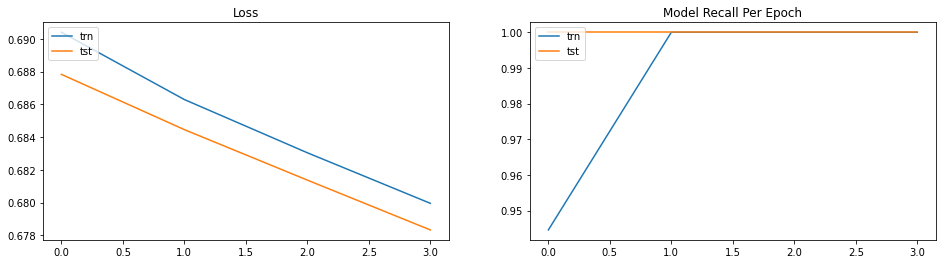

In [1008]:
# Plot it
import matplotlib.pyplot as p
fig, (axis1,axis2) = p.subplots(1,2, figsize=(16,4))
axis1.plot(h.history['loss'])
axis1.plot(h.history['val_loss'])
axis1.set_title('Loss')
axis1.legend(['trn', 'tst'], loc='upper left')
axis2.plot(h.history['rc'])
axis2.plot(h.history['val_rc'])
axis2.set_title('Model Recall Per Epoch')
axis2.legend(['trn', 'tst'], loc='upper left')
p.show()

In [1010]:

# compute MPR
# we implement per bit to handle memory issues
user_index = tstx['userId'].cat.codes.values
movie_index = tstx['movieId'].cat.codes.values
number_of_bits = 10
bits = np.array_split(np.arange(n_usrs), number_of_bits)
rs = []
prev_mx = 0
for i,indexx in enumerate(bits):
    print(f'Implementing bit : {i+1}/{number_of_bits}')
    cross_mvId = np.transpose([np.tile(np.arange(num_of_movies), len(indexx)), np.repeat(indexx, len(np.arange(num_of_movies)))])
    score = mdl.predict([cross_mvId[:,1], cross_mvId[:,0]], batch_size=50000, verbose=1).reshape(indexx.shape[0], num_of_movies)
    score = (-score).argsort() / score.shape[1]
    sl = (user_index >= indexx.min()) & (user_index <= indexx.max())
    bit_score = np.asarray(score[user_index[sl] - prev_mx, movie_index[sl]]).reshape(-1)
    rs.append(bit_score)
    prev_mx = indexx.max() + 1
mpr_N_C_F = np.concatenate(rs).sum()/len(tstx)
print(f'N_C_F MPR: {mpr_N_C_F:.5f}')
rc_deep_reac = (np.concatenate(rs) < 0.5).sum()/len(tstx)
print(f'N_C_F Model Recall rate: {rc_deep_reac:.5f}')

Implementing bit : 1/10
429/429 [==============================] - 11s 22ms/step
Implementing bit : 2/10
429/429 [==============================] - 9s 21ms/step
Implementing bit : 3/10
429/429 [==============================] - 11s 24ms/step
Implementing bit : 4/10
429/429 [==============================] - 12s 27ms/step
Implementing bit : 5/10
429/429 [==============================] - 9s 21ms/step
Implementing bit : 6/10
429/429 [==============================] - 9s 20ms/step
Implementing bit : 7/10
429/429 [==============================] - 9s 18ms/step
Implementing bit : 8/10
429/429 [==============================] - 9s 21ms/step
Implementing bit : 9/10
429/429 [==============================] - 9s 20ms/step
Implementing bit : 10/10
429/429 [==============================] - 9s 20ms/step
N_C_F MPR: 0.49186
N_C_F Model Recall rate: 0.51326


In [1011]:
#Make movie predictions using the deep learning model
tst_pred['score'] = list(np.concatenate(rs))
#Select the top 5 movieIds to recommend to a user
tsf = tst_pred.sort_values(['score'],ascending=False).groupby('userId').head(5)
tsf1 = tsf.sort_values('userId')
tsf1 = tsf1[['userId', 'movieId']]
tsf1.columns = ['userId', 'Recommended movieId']
tsf1.head(10)

,userId,Recommended movieId
676471,3,1276
158401,4,231
330433,4,410
633980,5,1225
260428,5,321
268965,5,334
85523,5,141
625960,5,1207
1540100,7,5292
630097,7,1207


#### Non-Negative Matrix Factorization

In [1012]:
def nmf(dt, prd,mdl):
    # normalize to obtain % significance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    S = mdl.fit_transform(scaled_df)
    K = mdl.components_

    # implement per bit to handle memory issues
    user_index = prd['userId'].cat.codes.values
    movie_index = prd['movieId'].cat.codes.values
    number_of_bits = 30
    bits = np.array_split(np.arange(S.shape[0]), number_of_bits)
    #r = Results
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (S[indexx].dot(K))
        scr = (-scr).argsort() / scr.shape[1]
        sel = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sel] - prev_mx, movie_index[sel]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)

Kk = 2

# NMF
#NNDSVD to handle sparsity
mdl_nmf = NMF(n_components = Kk, init = 'nndsvd', max_iter = 1000, tol = 0.1, random_state = 1)
Recommendations1 = nmf(trn_dt, tstx, mdl_nmf)
mpr_Non_Negative_Matrix_Factorization = Recommendations1.sum()/len(tstx)
print(f'NMF MPR', round(mpr_Non_Negative_Matrix_Factorization,5))
rec_Non_Negative_Matrix_Factorization = (Recommendations1 < 0.5).sum()/len(tstx)
print('mdl Recall rate', round(rec_Non_Negative_Matrix_Factorization,5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
NMF MPR 0.37234
mdl Recall rate 0.69477


# "Learning from sets data 2019" DATA:

>Source: https://grouplens.org/datasets/learning-from-sets-of-movies-2019/

In [1013]:
# Reading scores file
movie_scs = pd.read_csv('learning-from-sets-2019/item_ratings.csv',
                      names=['userId', 'movieId', 'rating', 'timestamp']
                      ).sort_values("timestamp")
#Drop r that have nonnumeric movie ID
movie_scs = movie_scs[movie_scs.movieId.str.isnumeric().isnull()]
#Convert data types for movieId and rating
movie_scs['movieId'] = pd.to_numeric(movie_scs.movieId)
movie_scs['rating'] = pd.to_numeric(movie_scs.rating)

# Reading movies file
movie_1 = pd.read_csv('learning-from-sets-2019/set_ratings.csv')

In [1014]:
ct = 'category' #Define global category descriptor
usrs = np.sort(scores.userId.unique()).tolist() # Get the unique customers
mvs = list(scores.movieId.unique()) # Get the unique products that were watched
rtng = list(scores.rating) # All of the watch history
r = scores.userId.astype(ct, usrs).cat.codes
# pull row indices
cols = scores.movieId.astype(ct, mvs).cat.codes
# pull column indices
usr_itm = sps.csr_matrix((rtng, (r, cols)), shape=(len(usrs), len(mvs)))
mtrx_sz = usr_itm.shape[0]*usr_itm.shape[1] # Total possible links
times_watched = len(usr_itm.nonzero()[0]) # Number of mvs interacted with
#sparsity
sprs = 100*(1 - (1.0*times_watched/mtrx_sz))

In [1015]:
movie_scs.head()

,userId,movieId,rating,timestamp
131258,1861f05e46,2001,3.5,2005-03-29 16:19:32
131132,1861f05e46,1250,3.5,2005-03-29 16:20:20
131105,1861f05e46,1204,3.5,2005-03-29 16:20:33
131235,1861f05e46,1876,3.0,2005-03-29 16:21:37
131600,1861f05e46,4886,5.0,2005-03-29 16:21:41


In [1016]:
print(times_watched, 'links')

print(len(mvs), 'movies')

print(len(usrs), 'Users')

10000054 links
10677 movies
69878 Users


## Exploratory Data Analysis(EDA)

In [1017]:
X = movie_scs[['userId', 'movieId',]]
y = movie_scs['rating']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)

In [1018]:
dfmvs.head(5)

,movieId,title,genres,userId,rating,timestamp
48035,5,Father of the Bride Part II (1995),Comedy,36008,2.0,823185224
48036,5,Father of the Bride Part II (1995),Comedy,36304,4.0,823264601
48037,5,Father of the Bride Part II (1995),Comedy,38104,4.0,825006881
48038,5,Father of the Bride Part II (1995),Comedy,38206,2.0,825009968
48039,5,Father of the Bride Part II (1995),Comedy,38326,4.0,825080156


### Distribution of users rating

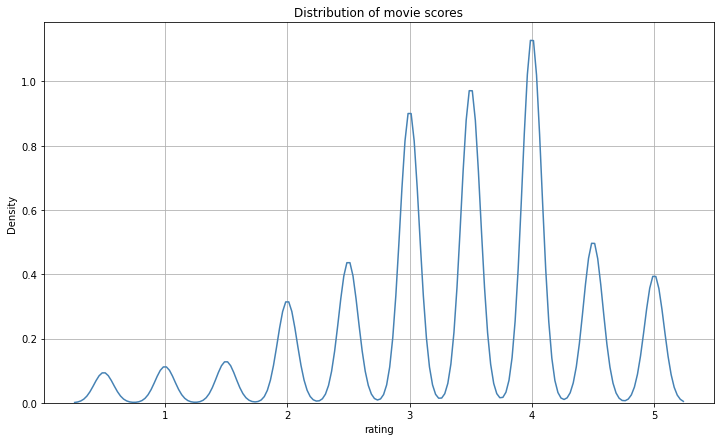

In [1019]:
p.figure(figsize=(12,7))
sns.kdeplot(movie_scs["rating"], color = 'steelblue');
p.title('Distribution of movie scores')
p.grid()
p.show()

In [1020]:
df_rtngs = dfmvs = movie_scs
df_rtngs.head(5)

,userId,movieId,rating,timestamp
131258,1861f05e46,2001,3.5,2005-03-29 16:19:32
131132,1861f05e46,1250,3.5,2005-03-29 16:20:20
131105,1861f05e46,1204,3.5,2005-03-29 16:20:33
131235,1861f05e46,1876,3.0,2005-03-29 16:21:37
131600,1861f05e46,4886,5.0,2005-03-29 16:21:41


In [1021]:
print("Shape of the dataframes: \n"+ " Rating DataFrame: "+ str(df_rtngs.shape)+"\n Movies DataFrame"+ str(dfmvs.shape))

Shape of the dataframes: 
 Rating DataFrame: (327899, 4)
 Movies DataFrame(327899, 4)


In [1022]:
scores_grouped_by_usrs = movie_scs.groupby('userId').agg([np.size, np.mean])

In [1023]:
scores_grouped_by_usrs.head(2)

movieId               rating          
              size          mean   size      mean
userId                                           
0011a9baea     172  53528.569767  172.0  4.151163
00be0326d6     277  34154.996390  277.0  2.444043

In [1024]:
#get shape of the resulting data
combine_mv_scs.shape

(10000054, 5)

Grouping the rating based on user

### Top 10 users who have rated most of the movies

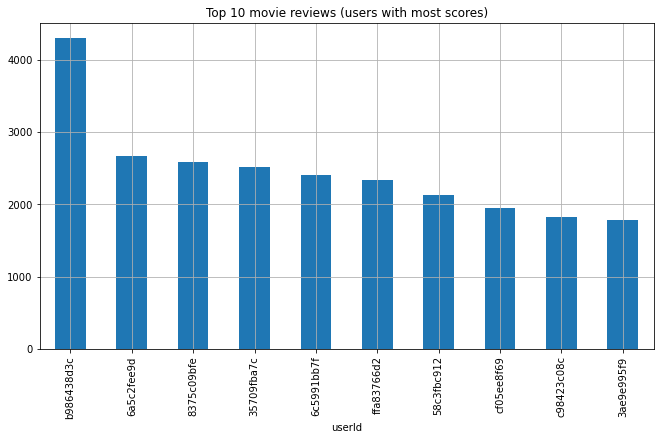

In [1025]:
#plot the top 10 movies
scores_grouped_by_usrs['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (11,6))
p.title('Top 10 movie reviews (users with most scores)')
p.grid()
p.show()

In [1026]:
#Group by movie id to get the mean rating of each movie
scores_mvs = combine_mv_scs.groupby('movieId').agg([np.mean], np.size)

In [1027]:
scores_mvs.shape

(10677, 2)

In [1028]:
scores_mvs.head(3)

,userId,rating
,mean,mean
movieId,,
1,35520.163787,3.928769
2,35868.424701,3.208070
3,35311.554685,3.150385


In [1029]:
#Remove movieid
scores_mvs = scores_mvs.drop('userId', axis=1)

### Movies with high average rating

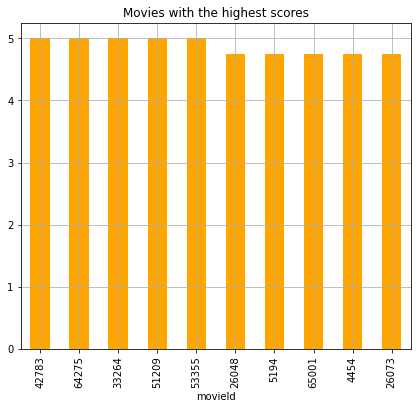

In [1030]:
#Plot movies with the highest average rating
scores_mvs['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='bar',
                                                                                       figsize=(7,6), color = 'orange');
p.title('Movies with the highest scores')
p.grid()
p.show()

### Movies with low average rating

In [1031]:
#Get movies that are rated less than 1.5
least_rated_mvs = scores_mvs['rating']['mean']< 1.5

In [1032]:
#Subset the movies using the mentioned criterion
rated_low = scores_mvs[least_rated_mvs]

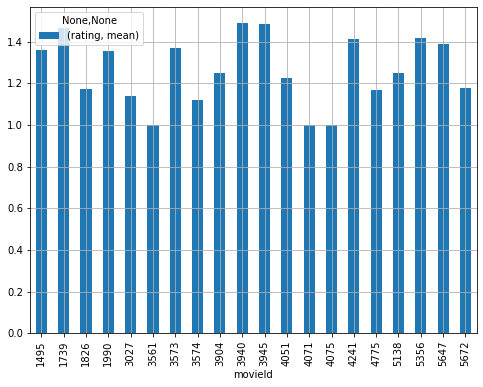

In [1033]:
#Plot the movies
rated_low.head(20).plot(kind='bar', figsize=(8,6));
p.grid()

In [1034]:
#Overview of 10 movies with the lowest rating
rated_low.head(10)

,rating
,mean
movieId,
1495,1.360227
1739,1.464286
1826,1.175214
1990,1.356436
3027,1.138889
3561,1.000000
3573,1.367647
3574,1.120253


In [1035]:
#Merge the ratings and movies dt
dfmvs = dfmv.merge(df_rtngs)
groupby = ['genres']
nonnormal = ['movieId']
dfmvs = dfmvs[dfmvs['genres'].isin(list(gnr_cnt.keys())[0:5])]

In [1036]:
tstTable = TableOne(dfmvs,columns = ['genres', 'rating'],
                   groupby=groupby, pval=True)

In [1037]:
tstTable

Grouped by genres                                                                                 
                            Missing      Overall      Action Adventure       Comedy        Drama    Thriller P-Value
n                                          34480         472        17        15967        16131        1893        
rating, n (%) 0.5                 0    705 (2.0)     8 (1.7)              541 (3.4)    141 (0.9)    15 (0.8)  <0.001
              1.0                      774 (2.2)    15 (3.2)              537 (3.4)    187 (1.2)    35 (1.8)        
              1.5                      974 (2.8)    33 (7.0)              648 (4.1)    255 (1.6)    38 (2.0)        
              2.0                     2322 (6.7)   71 (15.0)  2 (11.8)   1462 (9.2)    682 (4.2)   105 (5.5)        
              2.5                     3134 (9.1)   69 (14.6)  5 (29.4)  1771 (11.1)   1100 (6.8)  189 (10.0)        
              3.0                    6453 (18.7)  107 (22.7)  3 (17.6)  3288 (20.6)  2667 (16.5)  388 (20.5)        
              3.5                    6811 (19.8)   74 (15.7)  5 (29.4)  3095 (19.4)  3249 (20.1)  388 (20.5)        
              4.0                    7633 (22.1)   61 (12.9)   1 (5.9)  2835 (17.8)  4285 (26.6)  451 (23.8)        
              4.5                     3214 (9.3)    20 (4.2)   1 (5.9)   1030 (6.5)  1985 (12.3)   178 (9.4)        
              5.0                     2460 (7.1)    14 (3.0)              760 (4.8)   1580 (9.8)   106 (5.6)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: rating.

In [1038]:
tstTable.to_excel('summary_10M.xlsx')

In [1039]:
#Geenrate statistics related to genres and ratings
tstTable = TableOne(dfmvs,columns = ['genres', 'rating'],
                   groupby=groupby, categorical=['genres'], nonnormal=nonnormal, pval=True, tukey_test=True)

display(tstTable)
#Save to excel for use in the report
tstTable.to_excel('summary_10M_tst.xlsx')

Grouped by genres                                                                                           
                                      Missing       Overall       Action   Adventure         Comedy          Drama      Thriller P-Value
n                                                     34480          472          17          15967          16131          1893        
genres, n (%)     Action                    0     472 (1.4)  472 (100.0)                                                          <0.001
                  Adventure                        17 (0.0)               17 (100.0)                                                    
                  Comedy                       15967 (46.3)                           15967 (100.0)                                     
                  Drama                        16131 (46.8)                                          16131 (100.0)                      
                  Thriller                       1893 (5.5)                                                         1893 (100.0)        
rating, mean (SD)                           0     3.4 (1.0)    2.9 (1.0)   3.0 (0.7)      3.1 (1.1)      3.6 (0.9)     3.4 (0.9)  <0.001
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: genres.

#### Data Preparation

> (1)- Merge the dataframes to obtain complete information regarding a user, a movie and the corresponding interaction.

> (2)- Split the data into test and train.

##### Merge the dataframes

In [1040]:
#get distribution of the ratings data
df_rtngs.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [1041]:
dfmvs.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [1042]:
#Merge the dataframes
movie_scs = dfmvs.merge(df_rtngs)
movie_scs = movie_scs
movie_scs.head()

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,32fa802a3f,3.0,2005-10-29 11:28:32
1,5,Father of the Bride Part II (1995),Comedy,b986438d3c,2.5,2006-01-09 04:25:22
2,5,Father of the Bride Part II (1995),Comedy,211fea164a,3.5,2006-02-21 13:45:56
3,5,Father of the Bride Part II (1995),Comedy,1ded6fa4fe,2.0,2006-07-27 05:08:25
4,5,Father of the Bride Part II (1995),Comedy,d2243dbf2a,1.5,2006-12-11 15:42:37


##### Split the dataframes to test and train sets

In [1043]:
X = movie_scs[['userId', 'movieId']].values
y = movie_scs['rating'].values
#Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)


In [1044]:
X = movie_scs[['userId', 'movieId']]
y = movie_scs['rating']
#Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)
X_trn.shape, X_tst.shape, y_trn.shape, y_tst.shape

((24136, 2), (10344, 2), (24136,), (10344,))

#### Modeling

### Step 1. Define an index vector of all unique users and movies

In [1045]:
#Order the movies and users
c_mv = CategoricalDtype(sorted(movie_scs['movieId'].unique()), ordered=True)
c_usrr = CategoricalDtype(sorted(movie_scs['userId'].unique()), ordered=True)

In [1046]:
print(len(c_mv.categories))
print(len(c_usrr.categories))

1677
738


In [1047]:

trn, tst = train_test_split(X, test_size=0.30, random_state=420)
print(trn.shape)
print(tst.shape)

(24136, 2)
(10344, 2)


In [1048]:
tst = X_tst.copy()
trn = X_trn.copy()

tstx = tst.copy()

tstx['userId'] = tstx['userId'].astype(c_usrr)

tstx['movieId'] = tstx['movieId'].astype(c_mv)

tst_pred = tstx.copy()

In [1049]:
tstx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10344 entries, 31706 to 14000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   userId   10344 non-null  category
 1   movieId  10344 non-null  category
dtypes: category(2)
memory usage: 220.8 KB


### Step 1. Define an index vector of all unique users and movies

In [1050]:
#Order the movies and users
c_mv = CategoricalDtype(sorted(movie_scs['movieId'].unique()), ordered=True)
c_usrr = CategoricalDtype(sorted(movie_scs['userId'].unique()), ordered=True)

In [1051]:
print(len(c_mv.categories))
print(len(c_usrr.categories))

1677
738


In [1052]:

trn, tst = train_test_split(X, test_size=0.30, random_state=420)
print(trn.shape)
print(tst.shape)

(24136, 2)
(10344, 2)


In [1053]:
tst = X_tst.copy()
trn = X_trn.copy()

tstx = tst.copy()

tstx['userId'] = tstx['userId'].astype(c_usrr)

tstx['movieId'] = tstx['movieId'].astype(c_mv)

tst_pred = tstx.copy()

In [1054]:
tstx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10344 entries, 31706 to 14000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   userId   10344 non-null  category
 1   movieId  10344 non-null  category
dtypes: category(2)
memory usage: 220.8 KB


### Step 2: Define a 1's and 0's binary sparse matrix of User-movies for trning set

In [1055]:
trn_dt = csr_matrix((np.ones(len(trn)), (trn['userId'].astype(ct).cat.codes,
                                               trn['movieId'].astype(ct).cat.codes)), 
                  shape=( len(c_usrr.categories), len(c_mv.categories)))
print(f'{100*trn_dt.sum()/(trn_dt.shape[0]*trn_dt.shape[1])}% Sparsity')

1.9501852740650245% Sparsity


### Step 3. Run the model on the trning set

Models were tsting:

1. Cosine Similarity on movies

2. Non-negative matrix factorization

3. Neural Collaborative Filtering


Evaluation:
- Recall: % of 1s in the tst set
- MPR: Mean Percentile Rank

#### Cosine Similarity
Doing this in bits for the tst set so that we don't run into memory issues.   For the recall measure, if the track's relative percentile is < 0.5 then its a 1

In [1056]:
def nmf(dt, prd,mdl):
    # normalize to obtain % significance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    S = mdl.fit_transform(scaled_df)
    K = mdl.components_

    # implement per bit to handle memory issues
    user_index = prd['userId'].cat.codes.values
    movie_index = prd['movieId'].cat.codes.values
    number_of_bits = 30
    bits = np.array_split(np.arange(S.shape[0]), number_of_bits)
    #r = Results
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (S[indexx].dot(K))
        scr = (-scr).argsort() / scr.shape[1]
        sel = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sel] - prev_mx, movie_index[sel]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)

Kk = 2

# NMF
#NNDSVD to handle sparsity
mdl_nmf = NMF(n_components = Kk, init = 'nndsvd', max_iter = 1000, tol = 0.1, random_state = 1)
Recommendations1 = nmf(trn_dt, tstx, mdl_nmf)
mpr_Non_Negative_Matrix_Factorization = Recommendations1.sum()/len(tstx)
print(f'NMF MPR', round(mpr_Non_Negative_Matrix_Factorization,5))
rec_Non_Negative_Matrix_Factorization = (Recommendations1 < 0.5).sum()/len(tstx)
print('mdl Recall rate', round(rec_Non_Negative_Matrix_Factorization,5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
NMF MPR 0.49897
mdl Recall rate 0.51083


In [1057]:
def cos(dt, pred):
    
    #Cosine similarity model to generate a matrix and determine the closest recommendation depending on the similarity matrix
    # normalize to obtain % importance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    # implement model
    #s = similarity
    s = cosine_similarity(scaled_df.transpose())
    s[np.diag_indices(s.shape[0])] = 0
    denom = np.asarray(s.sum(axis=1)).reshape(-1)

    # implement per bit to handle memory issues
    user_index = pred['userId'].cat.codes.values
    movie_index = pred['movieId'].cat.codes.values

    number_of_bits = 30
    bits = np.array_split(np.arange(scaled_df.shape[0]), number_of_bits)
    #R = result
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (scaled_df[indexx].dot(s)) / denom
        scr = (-scr).argsort() / denom.shape[0]
        sl = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sl] - prev_mx, movie_index[sl]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)


# Evaluate performance of the model
Recommendations = cos(trn_dt, tstx)
mpr_cosine_sim = Recommendations.sum()/len(tstx)
print('MPR:', round(mpr_cosine_sim,5))
r_cosine_sim = (Recommendations < 0.5).sum()/len(tstx)
print('Model Recall rate:',round(r_cosine_sim, 5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
MPR: 0.51094
Model Recall rate: 0.48395


#### Neural Collaborative Filtering

In [1058]:
# Create the trning Set
sample_size_with_no_links = int(len(trn)*0.2)
n_usrs = c_usrr.categories.shape[0]
num_of_movies = c_mv.categories.shape[0]
# get trning set
trnx_usrs = trn['userId'].astype(ct).cat.codes.values
trnx_movies = trn['movieId'].astype(ct).cat.codes.values
trn_t = np.ones(len(trnx_usrs))
# add some negative samples
u = np.random.randint(n_usrs, size=sample_size_with_no_links)
i = np.random.randint(num_of_movies, size=sample_size_with_no_links)
non_neg_indexx = np.where(trn_dt[u,i] == 0)
trnx_usrs = np.concatenate([trnx_usrs, u[non_neg_indexx[1]]])
trnx_movies = np.concatenate([trnx_movies, i[non_neg_indexx[1]]])
trn_t = np.concatenate([trn_t, np.zeros(u[non_neg_indexx[1]].shape[0])])
print((trnx_usrs.shape, trnx_movies.shape, trn_t.shape))

# shuffle the data
X = np.stack([trnx_usrs, trnx_movies, trn_t], axis=1)
np.random.shuffle(X)

((28872,), (28872,), (28872,))


##### Model parameters

In [1059]:
#Output activation
actv = 'sigmoid'
#Intializer
intt = 'lecun_uniform'
#Layer name
nem = 'prediction'
#user input
u_t = 'user_input'
#item input
i_p = 'item_input'

In [1060]:

#usr_lt = user lt
def neural_network(number_of_usrs, num_movies, ld, regs=[0,0]):
    # model vars
    #user_p = user input
    usr_p = Input(shape=(1,), dtype='int64', name = u_t)
    itm_input = Input(shape=(1,), dtype='int64', name = i_p)
    #ld = lt dimension
    #mbds = embeddings
    #mbds_usrr = user embedding
    mbds_usrr = Embedding(input_dim = number_of_usrs, output_dim = ld, name = 'user_mbds', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    #mbds_itm = item emdeddings 
    mbds_itm = Embedding(input_dim = num_movies, output_dim = ld, name = 'itm_mbds',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # essential to define an embedding vector!
    usr_lt = Flatten()(mbds_usrr(usr_p))
    itm_lt = Flatten()(mbds_itm(itm_input))
    
    # user-itm embedding productper element
    prdvec = merge.Multiply()([usr_lt, itm_lt])
    
    # Final prd layer
    prd = Dense(1, activation=actv, kernel_initializer=intt, name = nem)(prdvec)
    #retutn md = model
    md = Model(inputs=[usr_p, itm_input], outputs=prd)
    
    return md

# create the recall function
def rc(y_rl, y_p):
    tp = Q.sum(Q.round(Q.clip(y_rl * y_p, 0, 1)))
    pos_pt = Q.sum(Q.round(Q.clip(y_rl, 0, 1)))
    rc = tp / (pos_pt + Q.epsilon())
    return rc

mdl = neural_network(n_usrs, num_of_movies, 50, regs = [0,0])

In [1061]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_mbds (Embedding)           (None, 1, 50)        36800       user_input[0][0]                 
__________________________________________________________________________________________________
itm_mbds (Embedding)            (None, 1, 50)        78050       item_input[0][0]                 
___________________________________________________________________________________________

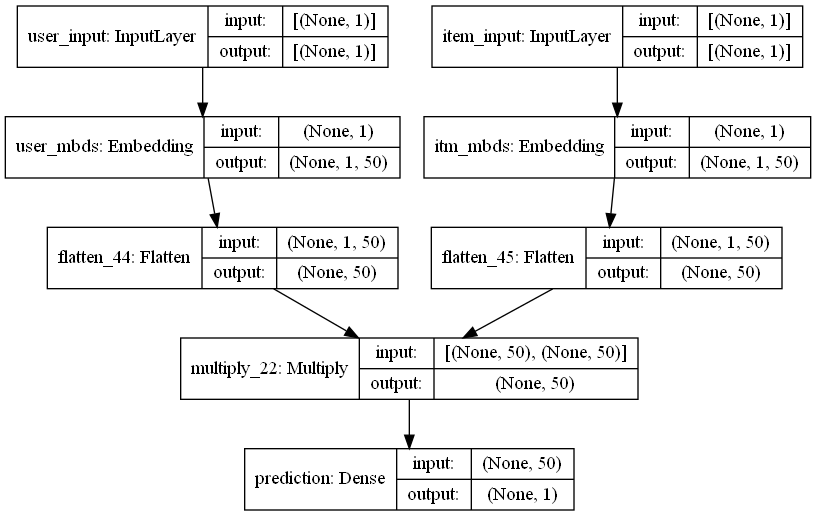

In [1062]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1063]:
#Output activation
actv = 'sigmoid'
#Intializer
intt = 'lecun_uniform'
#Layer name
nem = 'prediction'
#user input
u_t = 'user_input'
#item input
i_p = 'item_input'

In [1064]:


#usr_lt = user lt
def neural_network(number_of_usrs, num_movies, ld, regs=[0,0]):
    # model vars
    #user_p = user input
    usr_p = Input(shape=(1,), dtype='int64', name = u_t)
    itm_input = Input(shape=(1,), dtype='int64', name = i_p)
    #ld = lt dimension
    #mbds = embeddings
    #mbds_usrr = user embedding
    mbds_usrr = Embedding(input_dim = number_of_usrs, output_dim = ld, name = 'user_mbds', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    #mbds_itm = item emdeddings 
    mbds_itm = Embedding(input_dim = num_movies, output_dim = ld, name = 'itm_mbds',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # essential to define an embedding vector!
    usr_lt = Flatten()(mbds_usrr(usr_p))
    itm_lt = Flatten()(mbds_itm(itm_input))
    
    # user-itm embedding productper element
    prdvec = merge.Multiply()([usr_lt, itm_lt])
    
    # Final prd layer
    prd = Dense(1, activation=actv, kernel_initializer=intt, name = nem)(prdvec)
    #retutn md = model
    md = Model(inputs=[usr_p, itm_input], outputs=prd)
    
    return md


# create the model
def rc(yt, yp):
    tp = K.sum(K.round(K.clip(yt * yp, 0, 1)))
    pos_pt = K.sum(K.round(K.clip(yt, 0, 1)))
    recall = tp / (pos_pt + K.epsilon())
    return recall

mdl = neural_network(n_usrs, num_of_movies, 50, regs = [0,0])

mdl.compile(optimizer=RMSprop(lr=0.001), metrics = ['accuracy', rc],  loss='binary_crossentropy')

In [1065]:
# trn the Model
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
h =  mdl.fit([X[:,0], X[:,1]], X[:,2], batch_size=150000, epochs=20, validation_split = 0.1, verbose=1, callbacks = [early_stop])
score = mdl.evaluate([tstx['userId'].cat.codes.values, tstx['movieId'].cat.codes.values], np.ones(tstx.shape[0]), verbose=1, batch_size=100000)
print(f'tst Loss: {score[0]}   |   tst Recall: {score[1]}')

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6931 - accuracy: 0.5013 - rc: 0.5007 - val_loss: 0.6921 - val_accuracy: 0.8328 - val_rc: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 47ms/step - loss: 0.6920 - accuracy: 0.8363 - rc: 1.0000 - val_loss: 0.6913 - val_accuracy: 0.8328 - val_rc: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 60ms/step - loss: 0.6912 - accuracy: 0.8363 - rc: 1.0000 - val_loss: 0.6907 - val_accuracy: 0.8328 - val_rc: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 72ms/step - loss: 0.6906 - accuracy: 0.8363 - rc: 1.0000 - val_loss: 0.6901 - val_accuracy: 0.8328 - val_rc: 1.0000
Epoch 00004: early stopping
1/1 [==============================] - 0s 285ms/step - loss: 0.6886 - accuracy: 1.0000 - rc: 1.0000
tst Loss: 0.6886173486709595   |   tst Recall: 1.0


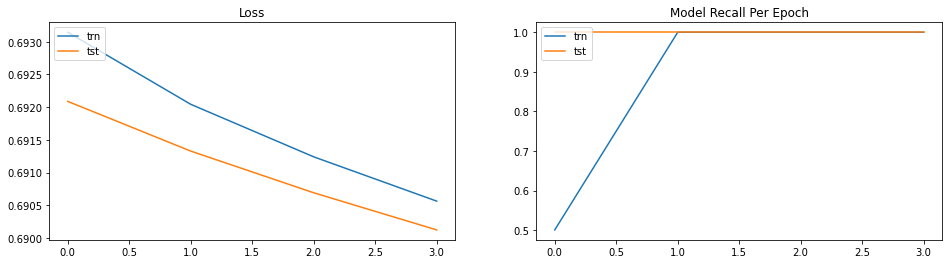

In [1066]:
# Plot it
import matplotlib.pyplot as p
fig, (axis1,axis2) = p.subplots(1,2, figsize=(16,4))
axis1.plot(h.history['loss'])
axis1.plot(h.history['val_loss'])
axis1.set_title('Loss')
axis1.legend(['trn', 'tst'], loc='upper left')
axis2.plot(h.history['rc'])
axis2.plot(h.history['val_rc'])
axis2.set_title('Model Recall Per Epoch')
axis2.legend(['trn', 'tst'], loc='upper left')
p.show()

In [1068]:

# compute MPR
# we implement per bit to handle memory issues
user_index = tstx['userId'].cat.codes.values
movie_index = tstx['movieId'].cat.codes.values
number_of_bits = 10
bits = np.array_split(np.arange(n_usrs), number_of_bits)
rs = []
prev_mx = 0
for i,indexx in enumerate(bits):
    print(f'Implementing bit : {i+1}/{number_of_bits}')
    cross_mvId = np.transpose([np.tile(np.arange(num_of_movies), len(indexx)), np.repeat(indexx, len(np.arange(num_of_movies)))])
    score = mdl.predict([cross_mvId[:,1], cross_mvId[:,0]], batch_size=50000, verbose=1).reshape(indexx.shape[0], num_of_movies)
    score = (-score).argsort() / score.shape[1]
    sel = (user_index >= indexx.min()) & (user_index <= indexx.max())
    bit_score = np.asarray(score[user_index[sel] - prev_mx, movie_index[sel]]).reshape(-1)
    rs.append(bit_score)
    prev_mx = indexx.max() + 1
mpr_N_C_F = np.concatenate(rs).sum()/len(tstx)
print(f'N_C_F MPR: {mpr_N_C_F:.5f}')
rc_deep_reac = (np.concatenate(rs) < 0.5).sum()/len(tstx)
print(f'N_C_F Model Recall rate: {rc_deep_reac:.5f}')

Implementing bit : 1/10
3/3 [==============================] - 0s 17ms/step
Implementing bit : 2/10
3/3 [==============================] - 0s 17ms/step
Implementing bit : 3/10
3/3 [==============================] - 0s 13ms/step
Implementing bit : 4/10
3/3 [==============================] - 0s 24ms/step
Implementing bit : 5/10
3/3 [==============================] - 0s 12ms/step
Implementing bit : 6/10
3/3 [==============================] - 0s 22ms/step
Implementing bit : 7/10
3/3 [==============================] - 0s 20ms/step
Implementing bit : 8/10
3/3 [==============================] - 0s 19ms/step
Implementing bit : 9/10
3/3 [==============================] - 0s 21ms/step
Implementing bit : 10/10
3/3 [==============================] - 0s 13ms/step
N_C_F MPR: 0.49824
N_C_F Model Recall rate: 0.50725


In [1069]:
#Make movie predictions using the deep learning model
tst_pred['score'] = list(np.concatenate(rs))
#Select the top 5 movieIds to recommend to a user
tsf = tst_pred.sort_values(['score'],ascending=False).groupby('userId').head(5)
tsf1 = tsf.sort_values('userId')
tsf1 = tsf1[['userId', 'movieId']]
tsf1.columns = ['userId', 'Recommended movieId']
tsf1.head(10)

,userId,Recommended movieId
4160,00be0326d6,520
5894,00be0326d6,1173
12344,00d8a48617,2788
7149,00d8a48617,1285
8742,00d8a48617,1938
21077,00d8a48617,4771
11524,00d8a48617,2694
10369,01da6d8da5,2357
2055,01da6d8da5,307
6726,01da6d8da5,1246


#### Non-Negative Matrix Factorization

In [1070]:
def nmf(dt, prd,mdl):
    # normalize to obtain % significance to user
    scaled_df = dt.multiply(1/dt.sum(axis=1)).tocsr()
    S = mdl.fit_transform(scaled_df)
    K = mdl.components_

    # implement per bit to handle memory issues
    user_index = prd['userId'].cat.codes.values
    movie_index = prd['movieId'].cat.codes.values
    number_of_bits = 30
    bits = np.array_split(np.arange(S.shape[0]), number_of_bits)
    #r = Results
    r = []
    prev_mx = 0
    for i,indexx in enumerate(bits):
        print(f'Implementing bit : {i+1}/{number_of_bits}')
        scr = (S[indexx].dot(K))
        scr = (-scr).argsort() / scr.shape[1]
        sl = (user_index >= indexx.min()) & (user_index <= indexx.max())
        bit_scr = np.asarray(scr[user_index[sl] - prev_mx, movie_index[sl]]).reshape(-1)
        r.append(bit_scr)
        prev_mx = indexx.max() + 1
    return np.concatenate(r)

Kk = 2

# NMF
#NNDSVD to handle sparsity
mdl_nmf = NMF(n_components = Kk, init = 'nndsvd', max_iter = 1000, tol = 0.1, random_state = 1)
Recommendations1 = nmf(trn_dt, tstx, mdl_nmf)
mpr_Non_Negative_Matrix_Factorization = Recommendations1.sum()/len(tstx)
print(f'NMF MPR', round(mpr_Non_Negative_Matrix_Factorization,5))
rec_Non_Negative_Matrix_Factorization = (Recommendations1 < 0.5).sum()/len(tstx)
print('mdl Recall rate', round(rec_Non_Negative_Matrix_Factorization,5))

Implementing bit : 1/30
Implementing bit : 2/30
Implementing bit : 3/30
Implementing bit : 4/30
Implementing bit : 5/30
Implementing bit : 6/30
Implementing bit : 7/30
Implementing bit : 8/30
Implementing bit : 9/30
Implementing bit : 10/30
Implementing bit : 11/30
Implementing bit : 12/30
Implementing bit : 13/30
Implementing bit : 14/30
Implementing bit : 15/30
Implementing bit : 16/30
Implementing bit : 17/30
Implementing bit : 18/30
Implementing bit : 19/30
Implementing bit : 20/30
Implementing bit : 21/30
Implementing bit : 22/30
Implementing bit : 23/30
Implementing bit : 24/30
Implementing bit : 25/30
Implementing bit : 26/30
Implementing bit : 27/30
Implementing bit : 28/30
Implementing bit : 29/30
Implementing bit : 30/30
NMF MPR 0.49897
mdl Recall rate 0.51083
